In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data Ingestion

In [2]:
df = pd.read_csv("AAPL.csv")

In [3]:
df.sort_index(ascending=True, axis=0, inplace=True)

In [4]:
new_df = df[["Date", "Close"]]

In [5]:
new_df.index = new_df["Date"]

In [6]:
new_df.drop("Date", axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
data = new_df.values

TOTAL_SIZE = 6447

STEP_SIZE = 60

TRAIN_SIZE = 5802

TEST_SIZE = 645

# Preprocessing

In [8]:
TOTAL_SIZE = len(data)
STEP_SIZE = 60
TRAIN_SIZE = int(TOTAL_SIZE * 0.9)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
# Fit the scaler based on training data. This is to prevent data leaking (I.e Fitting based on validation data)
scaler.fit(data[:TRAIN_SIZE])
data = scaler.transform(data)

The first x_arr entry will consist of the t=0 to t=59 closing prices


The first y_arr entry will consist of the t=60 closing price


We have a total of 6447 closing prices, and we will have 6387 n-grams

We will predict from t=60 to t=6446 *(Remember that despite TOTAL_SIZE = 6447, we predict till t=6446 because t STARTS FROM ZERO)

The first 60 numbers will only be used for making predictions (They will not be predicted). 


The last number will not be used for making predictions

In [10]:
x_arr = []
y_arr = []
for i in range(TOTAL_SIZE - STEP_SIZE):
  x_arr.append(data[i:i+STEP_SIZE, 0])
  y_arr.append(data[i+STEP_SIZE, 0])

We will have 6387 entries for x_arr, where each entry contains 60 numbers

In [11]:
x_arr, y_arr = np.array(x_arr), np.array(y_arr)

Our x_train will have 5742 entries (Used to PREDICT from t=60 to t=5801)
*   t=0 to t=59 PREDICTS t=60
*   t=5741 to t=5800 PREDICTS t=5801

TO calculate, use t+59 (NOT 60) because python is zero-indexed....

Our x_test will have 645 entires (Used to predict t=5802 to t=6446)
*   t=5742 to t=5801 PREDICTS t=5802
*   t=6386 to t=6445 PREDICTS t=6446

In [12]:
# x_train will predict the 60th to TRAIN_SIZE number (60-5742)
x_train, y_train = x_arr[:TRAIN_SIZE-STEP_SIZE], y_arr[:TRAIN_SIZE-STEP_SIZE]
# y_train will predict the 60+TRAIN_SIZE+1 to the TOTAL_SIZE number
x_test, y_test = x_arr[TRAIN_SIZE-STEP_SIZE:], y_arr[TRAIN_SIZE-STEP_SIZE:]

Essentially:
* y_train will contain t=60 to t=5801, totalling 5802 entries
* y_test will contain t=5802 to t=6446, totalling 645 entries

Our total dataset spans t=0 to t=6446, totalling 6447 entries

In [13]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [14]:
x_train.shape

(5742, 60, 1)

# Deep Learning

In [29]:
# Remember that input shape does not account for batch size, so ignore the 1051
model = Sequential([
                    LSTM(units=50,  activation="tanh", input_shape=(x_train.shape[1], x_train.shape[2])),
                    Dropout(0.1),
                    Dense(64, activation="relu"),
                    Dropout(0.1),
                    Dense(1, activation="linear")
])

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

model.fit(x_train, y_train, epochs=1, verbose=1)

180/180 [==============================] - 9s 13ms/step - loss: 0.0081 - mse: 0.0081


In [30]:
predicted = model.predict(x_test)
final = scaler.inverse_transform(predicted)

train_plot = new_df[:TRAIN_SIZE]
test_plot = new_df[TRAIN_SIZE:]
test_plot["Predictions"] = final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


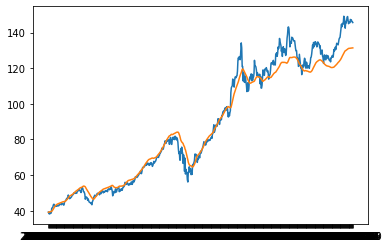

In [31]:
plt.plot(test_plot[['Close','Predictions']])

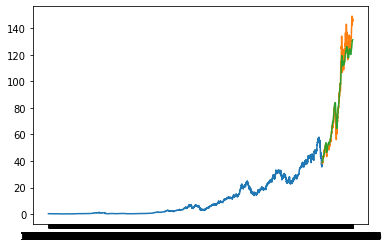

In [32]:
plt.plot(train_plot["Close"])
plt.plot(test_plot[['Close','Predictions']])

## Predict tomorrow

In [33]:
latest_price = new_df.values[-1][0]
# Get the last 60 numbers, to predict tomorrow's price
latest_ngram = new_df.values[-60:]

In [34]:
latest_ngram = scaler.transform(latest_ngram)
latest_ngram = np.array(latest_ngram)
latest_ngram = latest_ngram.reshape(1, -1, 1)
print(latest_ngram.shape)

(1, 60, 1)


In [35]:
tomorrow_prediction = model.predict(latest_ngram)
tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction)
tomorrow_prediction = tomorrow_prediction[0,0]

In [36]:
print(f"Today's price: {latest_price}")
print(f"Predicted Price Tomorrow: {tomorrow_prediction}")

Today's price: 145.600006
Predicted Price Tomorrow: 131.36097717285156


## Predict next 30 days

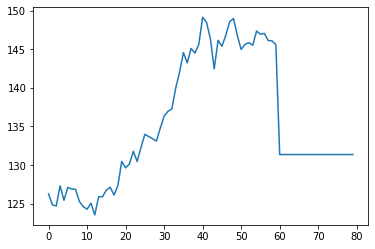

In [87]:
preds = new_df.values[-60:]

for i in range(20):
  ngram_preds = preds[-60:].reshape(-1,1)
  latest_ngram_transformed = scaler.transform(ngram_preds)
  latest_ngram_transformed = latest_ngram.reshape(1, -1, 1)

  next_pred = model.predict(latest_ngram_transformed)
  next_pred = scaler.inverse_transform(next_pred)
  preds = np.append(preds, next_pred[0,0])

plt.plot(preds)

# ARIMA

In [91]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.0 MB/s 
     |████████████████████████████████| 9.5 MB 13.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [15]:
import pmdarima

In [17]:
dataArima = new_df.values
train_arima = dataArima[-500: -100]
valid_arima = dataArima[-100:]

In [19]:
model = pmdarima.arima.auto_arima(train_arima, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(train_arima)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2031.351, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1940.522, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2028.156, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1864.067, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1869.483, Time=0.35 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1865.849, Time=0.82 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1865.875, Time=1.06 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1864.509, Time=0.59 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1867.850, Time=1.08 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=1865.920, Time=2.14 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [24]:
forecast = model.predict(n_periods=100)
forecast = forecast.reshape(-1,1)

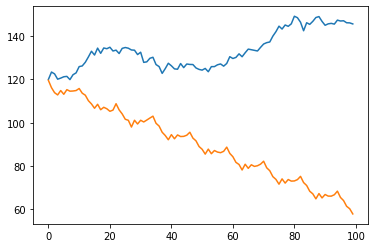

In [28]:
plt.plot(valid_arima)
plt.plot(forecast)